In [35]:
%%capture
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [36]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from tqdm.notebook import tqdm as tqdm
import pandas
import json
import pprint

In [37]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [38]:
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.get("https://www.autoscout24.it/lst?sort=age&desc=1&fuel=E&ustate=N%2CU&size=20&page=1&cy=I")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: use options instead of chrome_options
  """Entry point for launching an IPython kernel.


Populating the interactive namespace from numpy and matplotlib


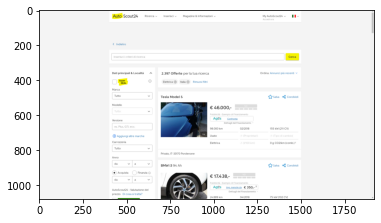

In [39]:
import time
wd.set_window_size(1920, 1080)
time.sleep(2)
wd.save_screenshot('screenshot.png')

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/screenshot.png')
imgplot = plt.imshow(img)
plt.show()

In [40]:
def loop_offer_pages(x):

  id = x.get_attribute("data-guid") #guid dell'annuncio
  try:
    page = x.find_element_by_css_selector(".cldt-summary-titles > a").get_attribute("href") #pagina dell'annauncio
    vehicle = x.find_element_by_css_selector(".cldt-summary-makemodel.sc-font-bold.sc-ellipsis").text
    price = x.find_elements_by_css_selector("""[data-item-name="price"]""")[0].text # 23 restituisce se c'è una rata, iva dedicibile etc
    vehicle_data = x.find_elements_by_css_selector(".cldt-summary-vehicle-data")[0].text.split("\n")
  except:
    page = ""
    vehicle = ""
    price = ""
    vehicle_data = ""
  try:
    vehicle_usr_desc = x.find_elements_by_css_selector(".cldt-summary-version")[0].text
  except:
     vehicle_usr_desc = ""
  seller_list = x.find_elements_by_css_selector("""[data-item-name="seller"]""")[0].text.split("\n")
  if seller_list[1].find('(') != -1:
    del seller_list[1]
  seller = seller_list[0]
  seller_country = seller_list[1]
  seller_address = seller_list[2]
  return {
      'id_annuncio': id,
      'link_annuncio': page,
      'vehicle': vehicle,
      'vehicle_user_desc' : vehicle_usr_desc,
      'asking_price' : price,
      'seller' : seller,
      'country' : seller_country,
      'address' : seller_address,
      }




In [41]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import numpy as np
import requests
import urllib.request
import os

path_offers_page = 'screenshot/offers_page/'
path_single_offers_page = 'screenshot/single_offer_page/'
path_offer_img = 'screenshot/single_offer_page/offer_img/'

try:
 os.makedirs(path_offers_page)
 os.makedirs(path_single_offers_page)
 os.makedirs(path_offer_img)
except:
  pass

#create blank list to enclose all offers page results
output_scraping = []
tipo_carrozzeria = [1,2,3,4,5,6,7,12]
fuel =  "B" #["B","D","E","L","C","2"]
condition = "N" #N nuovo, S KM0, U usato

for j in tqdm(tipo_carrozzeria):
  for i in tqdm(range(1,21)): #range to all pages is 21
    url = "https://www.autoscout24.it/lst/?sort=age&" + "offer=" + condition + "&desc=1&fuel=" + str(fuel) +" &ustate=N%2CU&size=20&page=" + str(i) + "&lon=9.18812&lat=45.46362&zip=Milano&zipr=200&cy=I&body=" + str(j) + "&atype=C&fc=14&qry=&"
    time.sleep(abs(np.random.normal(2,2)))
    wd.set_window_size(1920,1080)
    wd.get(url)
    try:
      WebDriverWait(wd, 15).until(
          EC.element_to_be_clickable((By.CSS_SELECTOR, "a.active")) #loads bottom bar, which is the last to be loaded in chromium
      )
    except:
      continue
    wd.save_screenshot(path_offers_page + str(i) + '.png')
    lista_annunci = wd.find_elements_by_css_selector(".cl-list-element.cl-list-element-gap")
    for x in lista_annunci:
      output_scraping.append(loop_offer_pages(x))
    if len(lista_annunci) < 20: #exit if there are less than 20 offers on 1 page
      break


In [42]:
print(output_scraping)

[{'id_annuncio': 'd2bd81a9-6bbe-4ab2-b445-190a7d2552bc', 'link_annuncio': 'https://www.autoscout24.it/annunci/mahindra-kuv100-k6-anche-gpl-vari-colori-pronta-cons-benzina-bianco-d2bd81a9-6bbe-4ab2-b445-190a7d2552bc?cldtidx=1&cldtsrc=listPage', 'vehicle': 'Mahindra KUV100', 'vehicle_user_desc': 'K6 ANCHE GPL, VARI COLORI, PRONTA CONS.', 'asking_price': '€ 9.900,- 1', 'seller': 'System Cars Srl', 'country': 'IT', 'address': '20821 Meda - Monza Brianza - Mb'}, {'id_annuncio': '6c288f3c-6f08-4889-9bf5-59d753bd61a1', 'link_annuncio': 'https://www.autoscout24.it/annunci/mini-john-cooper-works-2-0-231hp-auto-benzina-grigio-6c288f3c-6f08-4889-9bf5-59d753bd61a1?cldtidx=2&cldtsrc=listPage', 'vehicle': 'MINI John Cooper Works', 'vehicle_user_desc': '2.0 231hp Auto', 'asking_price': '€ 39.800,- 41', 'seller': 'AUTOCROCETTA SPA', 'country': 'IT', 'address': '10024 Moncalieri - Torino - To'}, {'id_annuncio': 'd627bdf2-0c8d-43bb-b9e2-91b41a60a7dc', 'link_annuncio': 'https://www.autoscout24.it/annunci

In [43]:
import json
export_output_scraping = open('pagina_di_ricerca_fuel_' + fuel + '_condition_' + condition + '.json', mode='w+')
export_output_scraping.write(json.dumps(output_scraping, indent=3))
export_output_scraping.close()

In [44]:
details_raw = []
details_value = wd.find_elements_by_css_selector("""[data-item-name="car-details"] >* dd""")
details_field = wd.find_elements_by_css_selector("""[data-item-name="car-details"] >* dt""")
for i in range(0,len(details_field)):
  details_raw_field = details_field[i].text
  details_raw_value = details_value[i].text
  if details_raw_value == "":
    details_raw_value = "Sì"
  details_raw.append(details_raw_field)
  details_raw.append(details_raw_value)

it = iter(details_raw) 
details = dict(zip(it, it)) 
print(details)

{}


In [45]:
def loop_single_offer_pages(k):
  url = k['link_annuncio']
  print (url)
  wd.set_window_size(1920,1080)
  wd.get(url)

  details_raw = []
  details_value = wd.find_elements_by_css_selector("""[data-item-name="car-details"] >* dd""")
  details_field = wd.find_elements_by_css_selector("""[data-item-name="car-details"] >* dt""")

  for m in range(0,len(details_field)):
    details_raw_field = details_field[m].text
    details_raw_value = details_value[m].text
    if details_raw_value == "":
      details_raw_value = "Sì"
    details_raw.append(details_raw_field)
    details_raw.append(details_raw_value)
  it = iter(details_raw) 
  details = dict(zip(it, it)) 
  details['id_annuncio'] = k['id_annuncio']
  print(details)
  
  return details

In [46]:
output_single_offers_scraping = []
import urllib.request

for i in tqdm(output_scraping):
  output_single_offers_scraping.append(loop_single_offer_pages(i))

https://www.autoscout24.it/annunci/mahindra-kuv100-k6-anche-gpl-vari-colori-pronta-cons-benzina-bianco-d2bd81a9-6bbe-4ab2-b445-190a7d2552bc?cldtidx=1&cldtsrc=listPage
{'Tipo di veicolo': 'Nuovo', 'Per neopatentati': 'Sì', 'Proprietari': '0', 'Usato Garantito': '36 mese', 'Marca': 'Mahindra', 'Modello': 'KUV100', 'Colore esterno': 'Bianco', 'Rivestimenti': 'Stoffa, Nero', 'Carrozzeria': 'City car', 'Porte': '5', 'Posti a sedere': '5', 'Versione per nazione': 'Italia', 'Tipo di cambio': 'Manuale', 'Marce': '5', 'Cilindrata': '1.198 cm³', 'Cilindri': '3', 'Peso a vuoto': '1.190 kg', 'Tipo di unità': 'anteriore', 'Alimentazione': 'Benzina', 'Consumo carburante:3': '6,2 l/100 km (comb.)\n7,5 l/100 km (urbano)\n5,4 l/100 km (extraurbano)', 'Emissioni di CO23': '146 g CO2/km (comb.)', 'Classe emissioni': 'Euro 6', 'id_annuncio': 'd2bd81a9-6bbe-4ab2-b445-190a7d2552bc'}
https://www.autoscout24.it/annunci/mini-john-cooper-works-2-0-231hp-auto-benzina-grigio-6c288f3c-6f08-4889-9bf5-59d753bd61a1?c

In [50]:
print (len(output_single_offers_scraping))

160


In [48]:
import json
export_output_single_offers_scraping = open('singole_pagine_fuel_' + fuel + '_condition_' + condition + '.json', mode='w+')
export_output_single_offers_scraping.write(json.dumps(output_single_offers_scraping, indent=3))
export_output_single_offers_scraping.close()